# k-Nearest Neigbours (kNN)

## Imports

In [1]:
import pandas as pd
import numpy as np

import sklearn.datasets
import sklearn.model_selection

import sklearn.neighbors as sn
import sklearn.metrics as skm

import matplotlib.pyplot as plt
import seaborn as sns

## Dataset

In [2]:
iris_data = sklearn.datasets.load_iris(as_frame=True)
iris_data

{'data':      sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
 0                  5.1               3.5                1.4               0.2
 1                  4.9               3.0                1.4               0.2
 2                  4.7               3.2                1.3               0.2
 3                  4.6               3.1                1.5               0.2
 4                  5.0               3.6                1.4               0.2
 ..                 ...               ...                ...               ...
 145                6.7               3.0                5.2               2.3
 146                6.3               2.5                5.0               1.9
 147                6.5               3.0                5.2               2.0
 148                6.2               3.4                5.4               2.3
 149                5.9               3.0                5.1               1.8
 
 [150 rows x 4 columns],
 'target': 0     

In [3]:
target_num2name = {ix: str(name) for ix, name in enumerate(iris_data['target_names'])}
feature_names = iris_data['feature_names']
iris_df = iris_data['frame']
iris_df['named_target'] = iris_df['target'].map(target_num2name)

## Classification

### Visualization for a 2D-feature space

In [4]:
import matplotlib.pyplot as plt

In [5]:
from sklearn.inspection import DecisionBoundaryDisplay

In [6]:
feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [7]:
feature2fit = [feature_names[ix] for ix in [0, 1]]
feature2fit

['sepal length (cm)', 'sepal width (cm)']

Accuracy: 72.0%


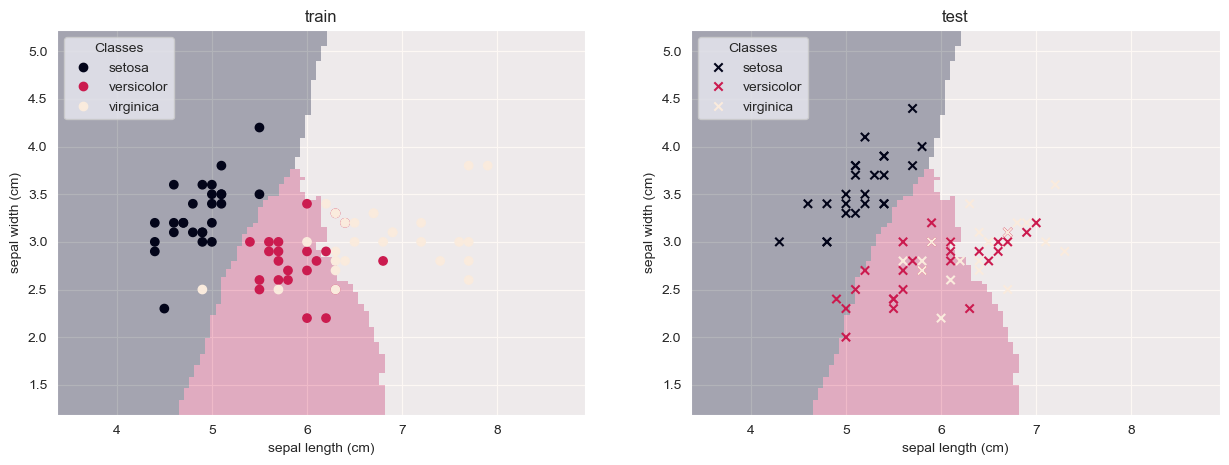

In [8]:
k = 10

train, test = sklearn.model_selection.train_test_split(iris_df, test_size=0.5)

knn = sn.KNeighborsClassifier(n_neighbors=k)
knn.fit(X = train[feature2fit], y=train['named_target'])

test_pred = knn.predict(test[feature2fit])
acc = skm.accuracy_score(test['named_target'], test_pred)


print(f'Accuracy: {100*acc:.1f}%')

fig, axes = plt.subplots(1, 2, figsize=(15,5))
splits = [('train', train, 'o'), ('test', test, 'x')]
for i in range(2):

    split_name, split, marker = splits[i]
    ax = axes[i]
    
    disp = DecisionBoundaryDisplay.from_estimator(
        knn,
        train[feature2fit],
        response_method="predict",
        plot_method="pcolormesh",
        shading="auto",
        alpha=0.3,
        ax = ax
    )
    
    scatter = ax.scatter(split[feature2fit[0]], split[feature2fit[1]], c=split['target'], marker=marker)
    _ = ax.legend(
        scatter.legend_elements()[0],
        target_num2name.values(),
        loc="upper left",
        title="Classes",
    )
    _ = ax.set_title(split_name)

### What is the best k?

Every train-test split generates different accuracy values for the test set. 
What can we observe if we repeat the calculation for different splits?

In [9]:
from collections import defaultdict

repetition = 50 # how many different train test-splits should be performed
k_values = range(1, 102, 5) # which k-values to evaluate

feature2fit = feature_names # build feature space with which features?

results = defaultdict(list) # collect results
for k in k_values:    
    for _ in range(repetition):

        # create random train-test split
        train, test = sklearn.model_selection.train_test_split(iris_df, test_size = 0.1)

        # fit the model and calculate test-error
        model = sn.KNeighborsClassifier(n_neighbors=k)
        model.fit(X = train[feature2fit], y=train['named_target'])
        test_pred = model.predict(test[feature2fit])
        acc = skm.accuracy_score(test['named_target'], test_pred)

        # collect the results in a dictionary
        results[k].append(acc)

In [10]:
# convert to DataFrame 
result_df = pd.DataFrame.from_dict(results)
result_df.head(3)

,1,6,11,16,21,26,31,36,41,46,...,56,61,66,71,76,81,86,91,96,101
0,0.933333,0.933333,0.933333,1.000000,0.933333,0.866667,0.933333,0.933333,1.000000,1.000000,...,1.000000,1.000000,0.800000,0.866667,1.000000,0.933333,0.466667,0.200000,0.733333,0.733333
1,0.933333,0.933333,0.800000,0.933333,1.000000,0.800000,1.000000,1.000000,1.000000,0.866667,...,0.866667,0.866667,0.733333,0.733333,0.800000,1.000000,1.000000,0.733333,0.800000,0.866667
2,0.866667,0.933333,0.933333,0.933333,1.000000,0.933333,0.866667,1.000000,0.933333,0.933333,...,0.933333,0.866667,0.933333,0.933333,0.866667,0.933333,1.000000,0.800000,0.600000,0.666667


To facilitate plotting, we convert the result table from a wide to a long format (see e.g. https://www.thedataschool.co.uk/luke-bennett/long-vs-wide-data-tables/)

In [11]:
result_df_long = (result_df
    .stack()
    .rename('Accuracy')
    .reset_index()
    .rename(columns={'level_0': 'iter', 'level_1': 'k'})
)

result_df_long.head()

,iter,k,Accuracy
0,0,1,0.933333
1,0,6,0.933333
2,0,11,0.933333
3,0,16,1.000000
4,0,21,0.933333


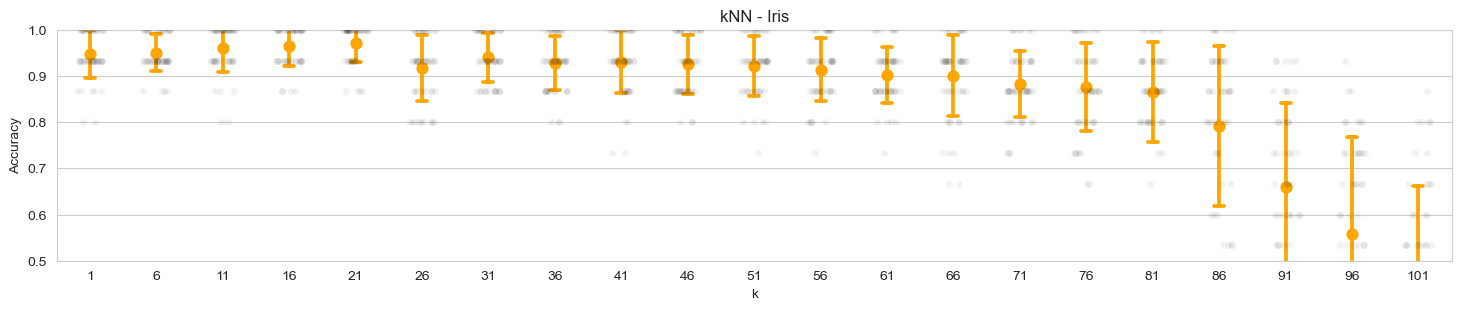

In [12]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(1,1, figsize = (18, 3))

sns.stripplot(
    result_df_long,
    x = 'k',
    y = 'Accuracy',
    alpha=0.05,
    color = 'k',
    ax = ax,
    jitter = 0.2
)

sns.pointplot(
    result_df_long, 
    x = 'k',
    y = 'Accuracy', 
    errorbar = "sd", 
    capsize = .15,
    color = 'orange',
    linestyle = '',
    ax = ax
)

_ = ax.set_ylim([0.5, 1])
_ = ax.set_title('kNN - Iris')

In scikit-learn we do not need to program this ourselfs, but we can utilize the `cross_val_score`

In [13]:
import sklearn.model_selection as sms

sms.cross_val_score(
    sn.KNeighborsClassifier(n_neighbors=10), 
    X = iris_df[feature_names], 
    y = iris_df['named_target'],
    scoring = 'accuracy', 
    cv = sms.ShuffleSplit(n_splits = 50, test_size = 0.2)
)

array([0.96666667, 1.        , 0.96666667, 1.        , 0.96666667,
       0.93333333, 1.        , 0.96666667, 0.93333333, 1.        ,
       0.96666667, 0.96666667, 0.93333333, 0.96666667, 1.        ,
       0.9       , 0.83333333, 1.        , 0.93333333, 1.        ,
       0.93333333, 0.96666667, 1.        , 0.96666667, 0.93333333,
       0.96666667, 1.        , 0.9       , 0.96666667, 0.96666667,
       1.        , 0.93333333, 0.96666667, 1.        , 1.        ,
       0.96666667, 0.96666667, 0.93333333, 0.93333333, 0.96666667,
       1.        , 0.93333333, 0.93333333, 0.86666667, 0.96666667,
       1.        , 1.        , 1.        , 1.        , 1.        ])

Instead of random train-test splits we can also employ other schemas like `LeaveOneOut`

In [14]:
for k in k_values:    

    train, test = sklearn.model_selection.train_test_split(iris_df, test_size = 0.1)
    
    score = sms.cross_val_score(
        sn.KNeighborsClassifier(n_neighbors=k), 
        X = train[feature_names], 
        y = train['named_target'],
        scoring = 'accuracy', 
        cv = sms.LeaveOneOut()
    ).mean()
    print(f'{k}: {score:.2f}')

1: 0.96
6: 0.97
11: 0.96
16: 0.96
21: 0.96
26: 0.94
31: 0.96
36: 0.95
41: 0.93
46: 0.90
51: 0.94
56: 0.90
61: 0.90
66: 0.89
71: 0.86
76: 0.87
81: 0.86
86: 0.76
91: 0.70
96: 0.78
101: 0.35


## kNN - Regression

### Visualization for a 2D-feature space

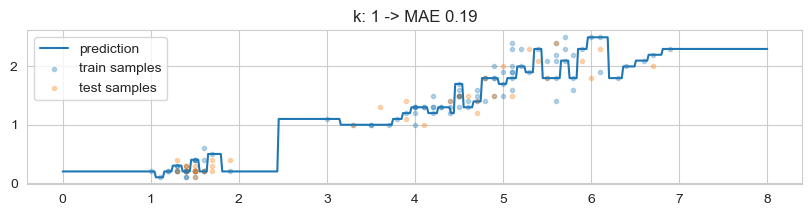

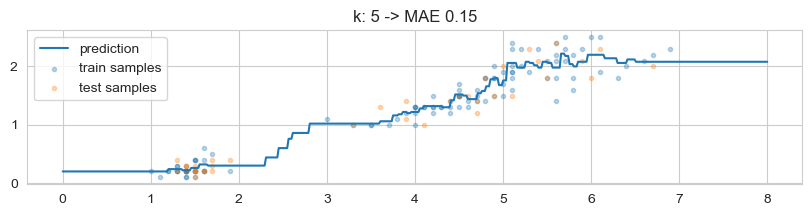

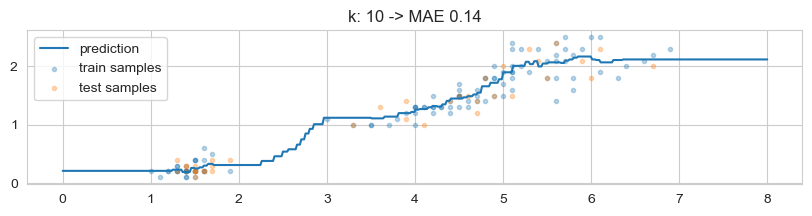

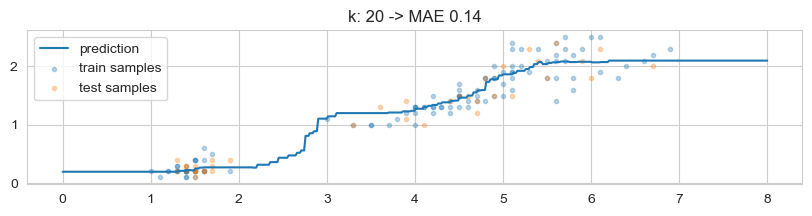

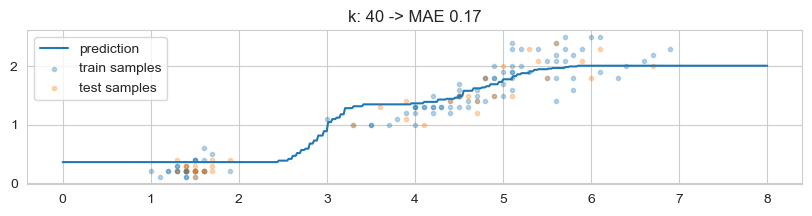

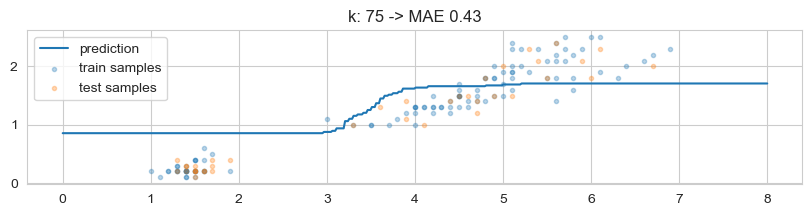

In [15]:
train, test = sklearn.model_selection.train_test_split(iris_df, random_state=23)


for k in [1, 5, 10, 20, 40, 75]:
    
    # fit
    knn = sn.KNeighborsRegressor(k)
    knn.fit(X = train[['petal length (cm)']], y = train['petal width (cm)'])

    # predict
    test_prediction = knn.predict(test[['petal length (cm)']])
    
    # calculate error
    mean_absolute_error = skm.mean_absolute_error(test[['petal width (cm)']], test_prediction)

    # create new figure
    plt.figure(figsize=(10,2))

    # plot prediction ine
    x_test = pd.DataFrame(np.linspace(0, 8, 500), columns=['petal length (cm)'])
    plt.plot(x_test, knn.predict(x_test), label=f'prediction')    

    #plot_datapoints
    plt.scatter(train[['petal length (cm)']], train['petal width (cm)'], marker='.', alpha=0.3, label='train samples')
    plt.scatter(test[['petal length (cm)']], test['petal width (cm)'], marker='.', alpha=0.3, label='test samples')
    
    plt.legend(loc='upper left')
    plt.title(f'k: {k} -> MAE {mean_absolute_error:.2f}')

### What is the best k?

In [16]:
from collections import defaultdict

repetition = 100 # how many different train test-splits should be performed
k_values = range(1, 40, 2) # which k-values to evaluate

feature2fit = ['petal length (cm)', 'sepal length (cm)', 'sepal width (cm)'] # build feature space with which features?
target = 'petal width (cm)'

results = {} # collect results
for k in k_values:    
    score = sms.cross_val_score(
        sn.KNeighborsRegressor(n_neighbors=k), 
        X = iris_df[feature2fit], 
        y = iris_df[target],
        scoring = 'neg_mean_absolute_error', 
        cv = sms.ShuffleSplit(n_splits = repetition, test_size = 0.2)
    )
    results[k] = score

In [17]:
result_df = pd.DataFrame.from_dict(results)
result_df_long = (result_df
    .stack()
    .rename('MAE')
    .reset_index()
    .rename(columns={'level_0': 'iter', 'level_1': 'k'})
)

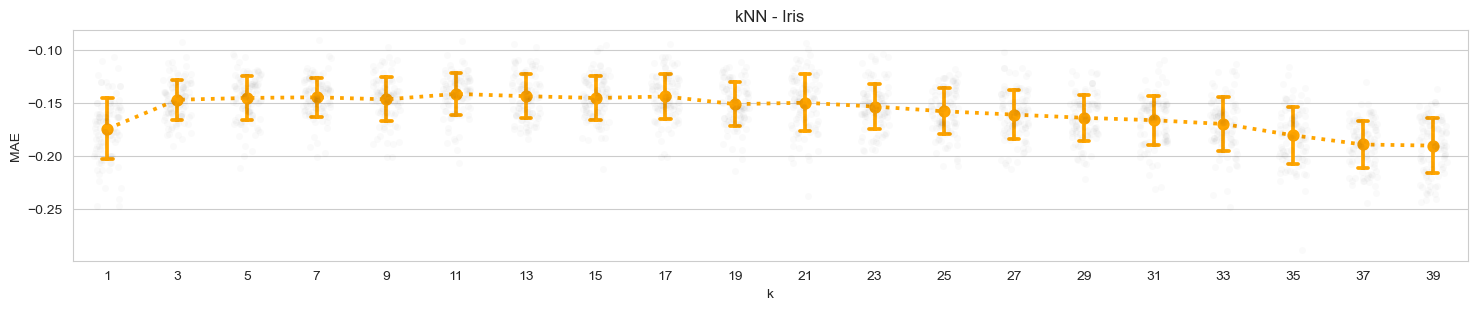

In [18]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(1,1, figsize = (18, 3))

sns.stripplot(
    result_df_long,
    x = 'k',
    y = 'MAE',
    alpha=0.02,
    color = 'k',
    ax = ax,
    jitter = 0.2
)

sns.pointplot(
    result_df_long, 
    x = 'k',
    y = 'MAE', 
    errorbar = "sd", 
    capsize = .15,
    color = 'orange',
    linestyle = ':',
    ax = ax
)

_ = ax.set_title('kNN - Iris')